In [1]:
import sys, os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import shapely
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.api as sm
import statsmodels.formula.api as smf
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
from gnt.data.common.geobox.geobox import get_or_create_geobox
from odc.geo import CRS
from odc.geo.xr import ODCExtensionDa, assign_crs, xr_reproject
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

def round_coords(ds):
    ds_cp = ds.copy()
    for coord_name in ds_cp.sizes.keys():
        if coord_name in ["latitude", "longitude", "y", "x"]:
            ds_cp.coords[coord_name] = ds_cp.coords[coord_name].values.round(5)
    return ds_cp

In [2]:
modis = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/modis_timeseries_reprojected.zarr", consolidated = False)
modis = modis.rio.write_crs(4326)

In [3]:
viirs = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/eog/viirs/processed/stage_2/viirs_annual_timeseries_reprojected.zarr")
viirs = viirs.rio.write_crs(4326)

In [4]:
land_mask = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/osm/land_mask.zarr")
land_mask = land_mask.rio.write_crs(4326)

In [5]:
cluster = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/gadm/countries_grid.zarr", consolidated = False).subdivisions
cluster = cluster.rio.write_crs(4326)

In [6]:
subset_box = riyadh = (46.3, 23.5, 47.5, 25.1) # heat island visible in cross section, small and negative coef

In [7]:
modis_subset = modis.rio.clip_box(*subset_box)["median"].compute().rename("modis_lst").ffill("latitude", 2)
viirs_subset = viirs.rio.clip_box(*subset_box)["viirs_annual"].compute().rename("viirs_radiance")
land_mask_subset = land_mask.rio.clip_box(*subset_box)["land_mask"].compute()

In [8]:
merged = xr.merge([round_coords(modis_subset), round_coords(viirs_subset), round_coords(land_mask_subset)], compat='override', join='inner')
merged = merged.where(merged.land_mask)

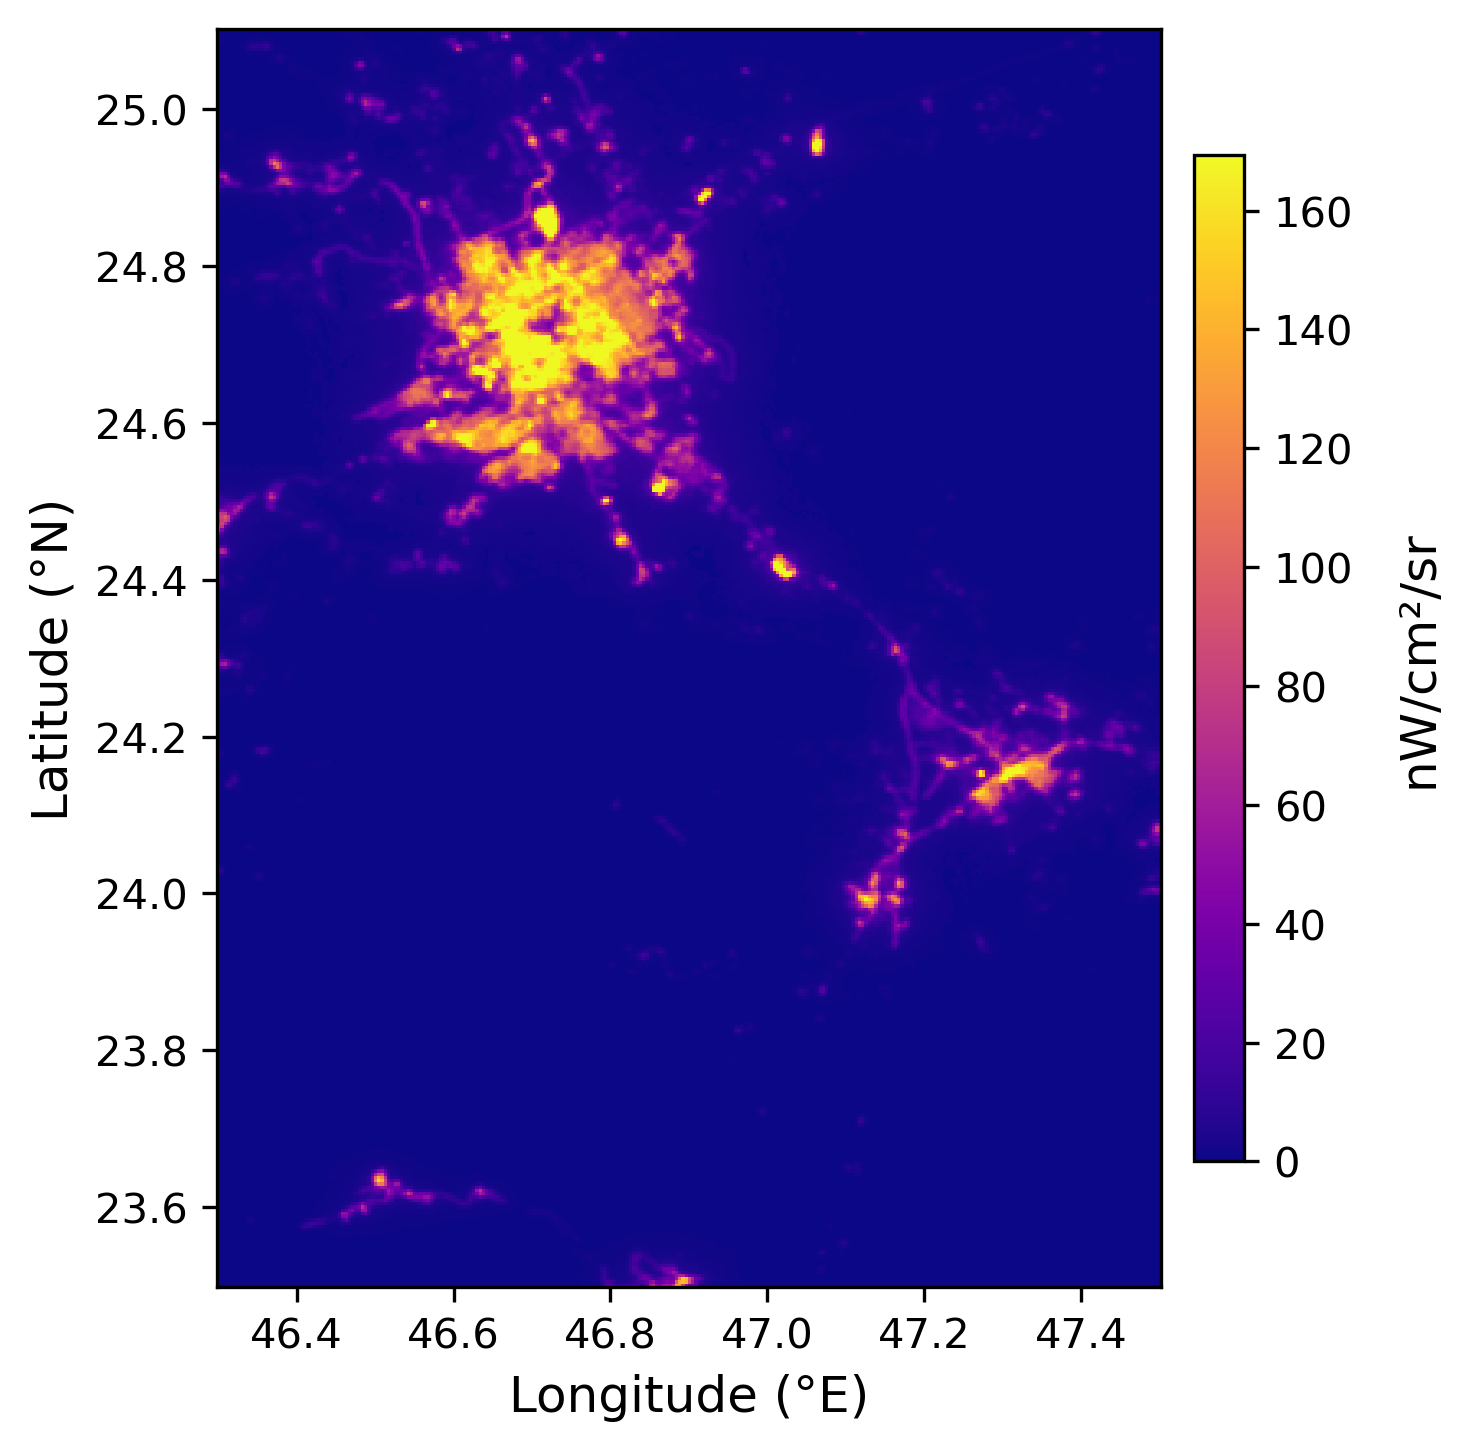

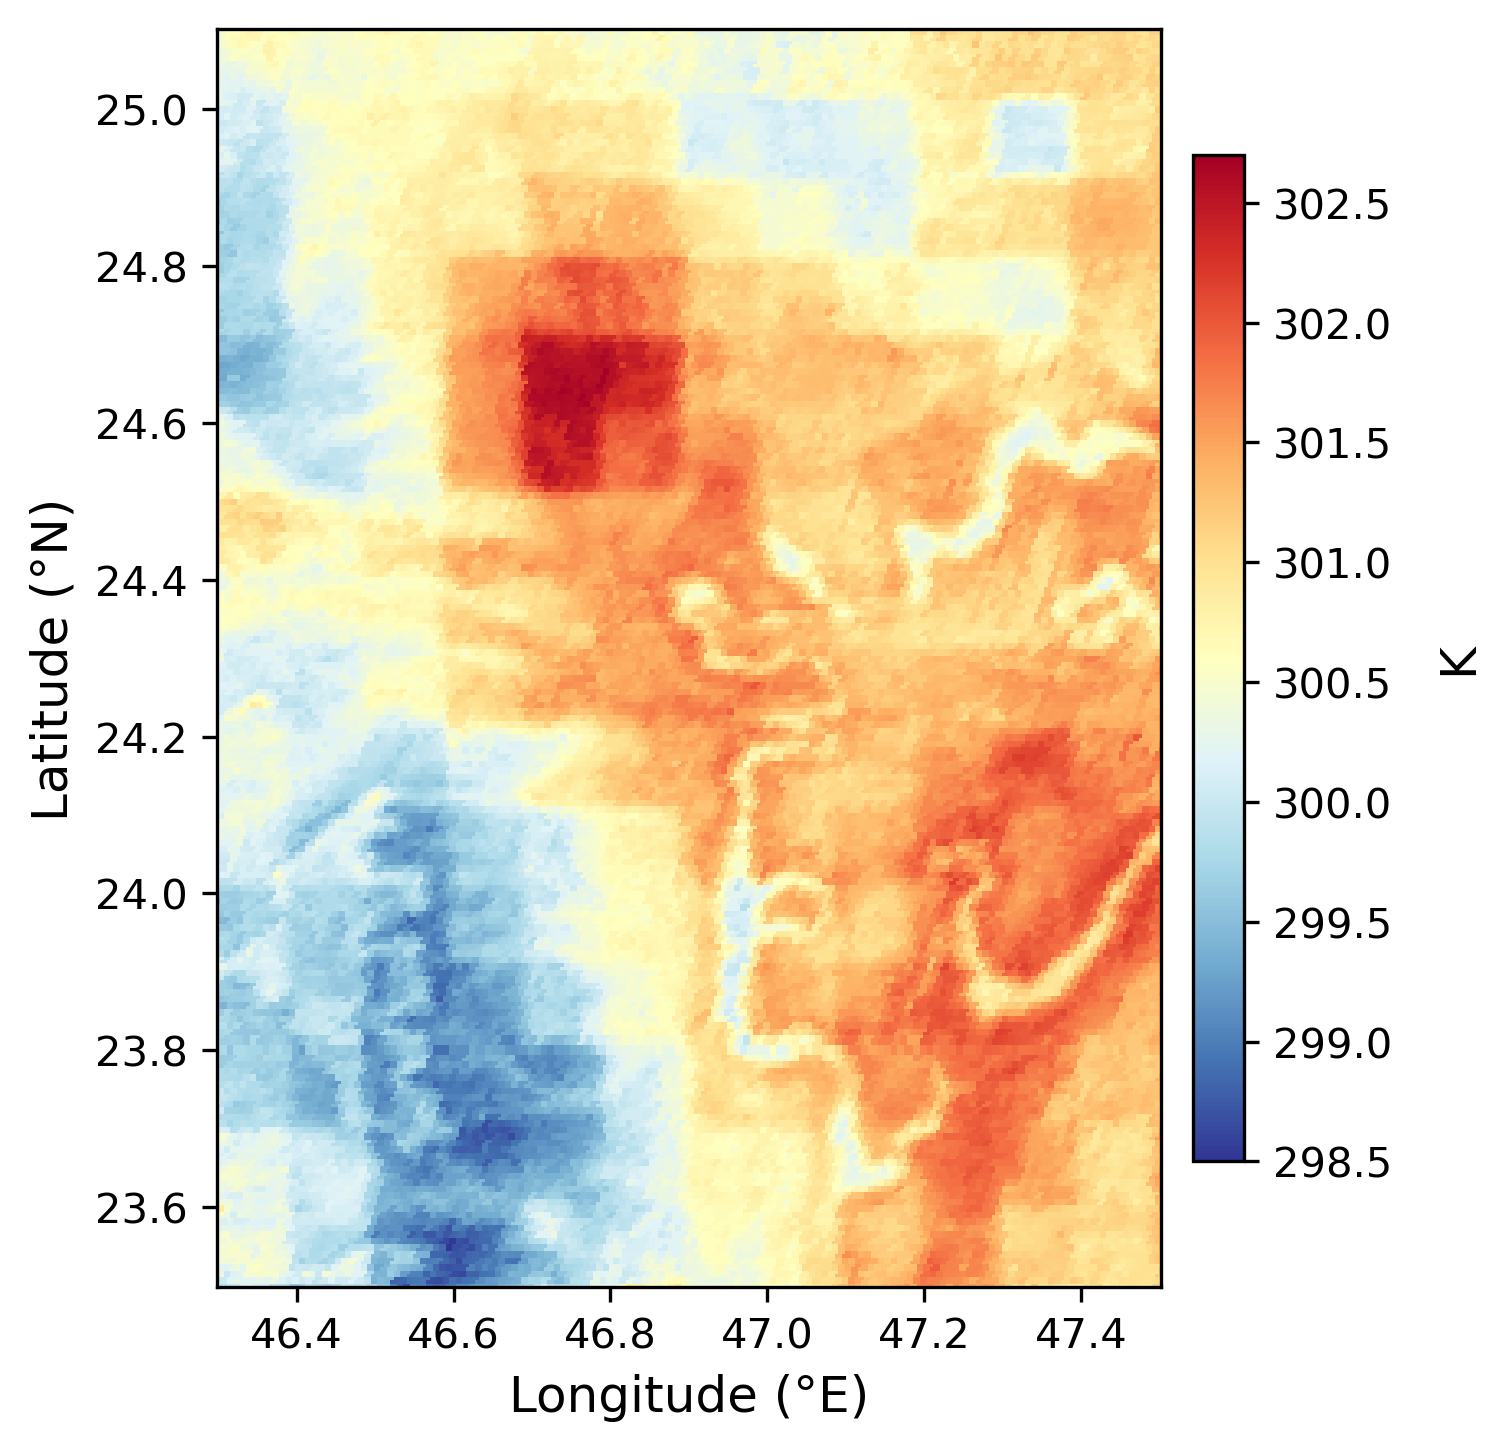

In [9]:
# Set style for poster quality
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 300  # High DPI for poster quality
})

qq_vmax = merged.viirs_radiance.quantile(.99)

# Plot 1: VIIRS radiance
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 5))
im1 = merged.isel(time=0).drop_vars(["band", "time", "spatial_ref"]).squeeze().viirs_radiance.plot.imshow(
    ax=ax1, 
    vmin=0, 
    vmax=qq_vmax,
    cmap='plasma',
    add_colorbar=False
)
ax1.set_xlabel('Longitude (°E)')
ax1.set_ylabel('Latitude (°N)')
ax1.set_aspect('equal')
ax1.tick_params(labelsize=10)

# Clean colorbar for VIIRS
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, pad=0.02)
cbar1.set_label('nW/cm²/sr', rotation=90, labelpad=10)

plt.tight_layout()
plt.savefig('riyadh_viirs_radiance.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Plot 2: MODIS LST
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 5))
im2 = merged.isel(time=0).drop_vars(["band", "time", "spatial_ref"]).squeeze().modis_lst.plot.imshow(
    ax=ax2,
    cmap='RdYlBu_r',
    add_colorbar=False
)
ax2.set_xlabel('Longitude (°E)')
ax2.set_ylabel('Latitude (°N)')
ax2.set_aspect('equal')
ax2.tick_params(labelsize=10)

# Clean colorbar for MODIS LST
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, pad=0.02)
cbar2.set_label('K', rotation=90, labelpad=10)

plt.tight_layout()
plt.savefig('riyadh_modis_lst.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [10]:
from odc.geo.geom import Geometry

#cities = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/raw/cities/urbanspatial-guppd-v1-gpkg.gpkg", engine = "pyogrio", layer="urbanspatial_guppd_v1_polygons")
countries = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/gadm/gadm_levelADM_0_simplified.gpkg")
subset_geom = Geometry(countries.query("GID_0=='UGA'").geometry.iloc[0], crs=4326)

In [11]:
modis_subset = modis.odc.crop(subset_geom)["median"].compute().rename("modis_lst").ffill("latitude", 2)
viirs_subset = viirs.odc.crop(subset_geom)["viirs_annual"].compute().rename("viirs_radiance")
land_mask_subset = land_mask.odc.crop(subset_geom)["land_mask"].compute()
cluster_subset = cluster.odc.crop(subset_geom).compute()

In [12]:
merged = xr.merge([round_coords(modis_subset), round_coords(viirs_subset), round_coords(land_mask_subset), round_coords(cluster_subset)], compat='override', join='inner')
# merged = xr.merge([round_coords(modis_subset), round_coords(dmsp_ext_subset), round_coords(land_mask_subset)], compat='override', join='outer')
merged = merged.where(merged.land_mask)

In [22]:
viirs_subset_ld.median()

<xarray.DataArray 'viirs_radiance' ()> Size: 8B
array(0.)
Coordinates:
    spatial_ref  int64 8B 0

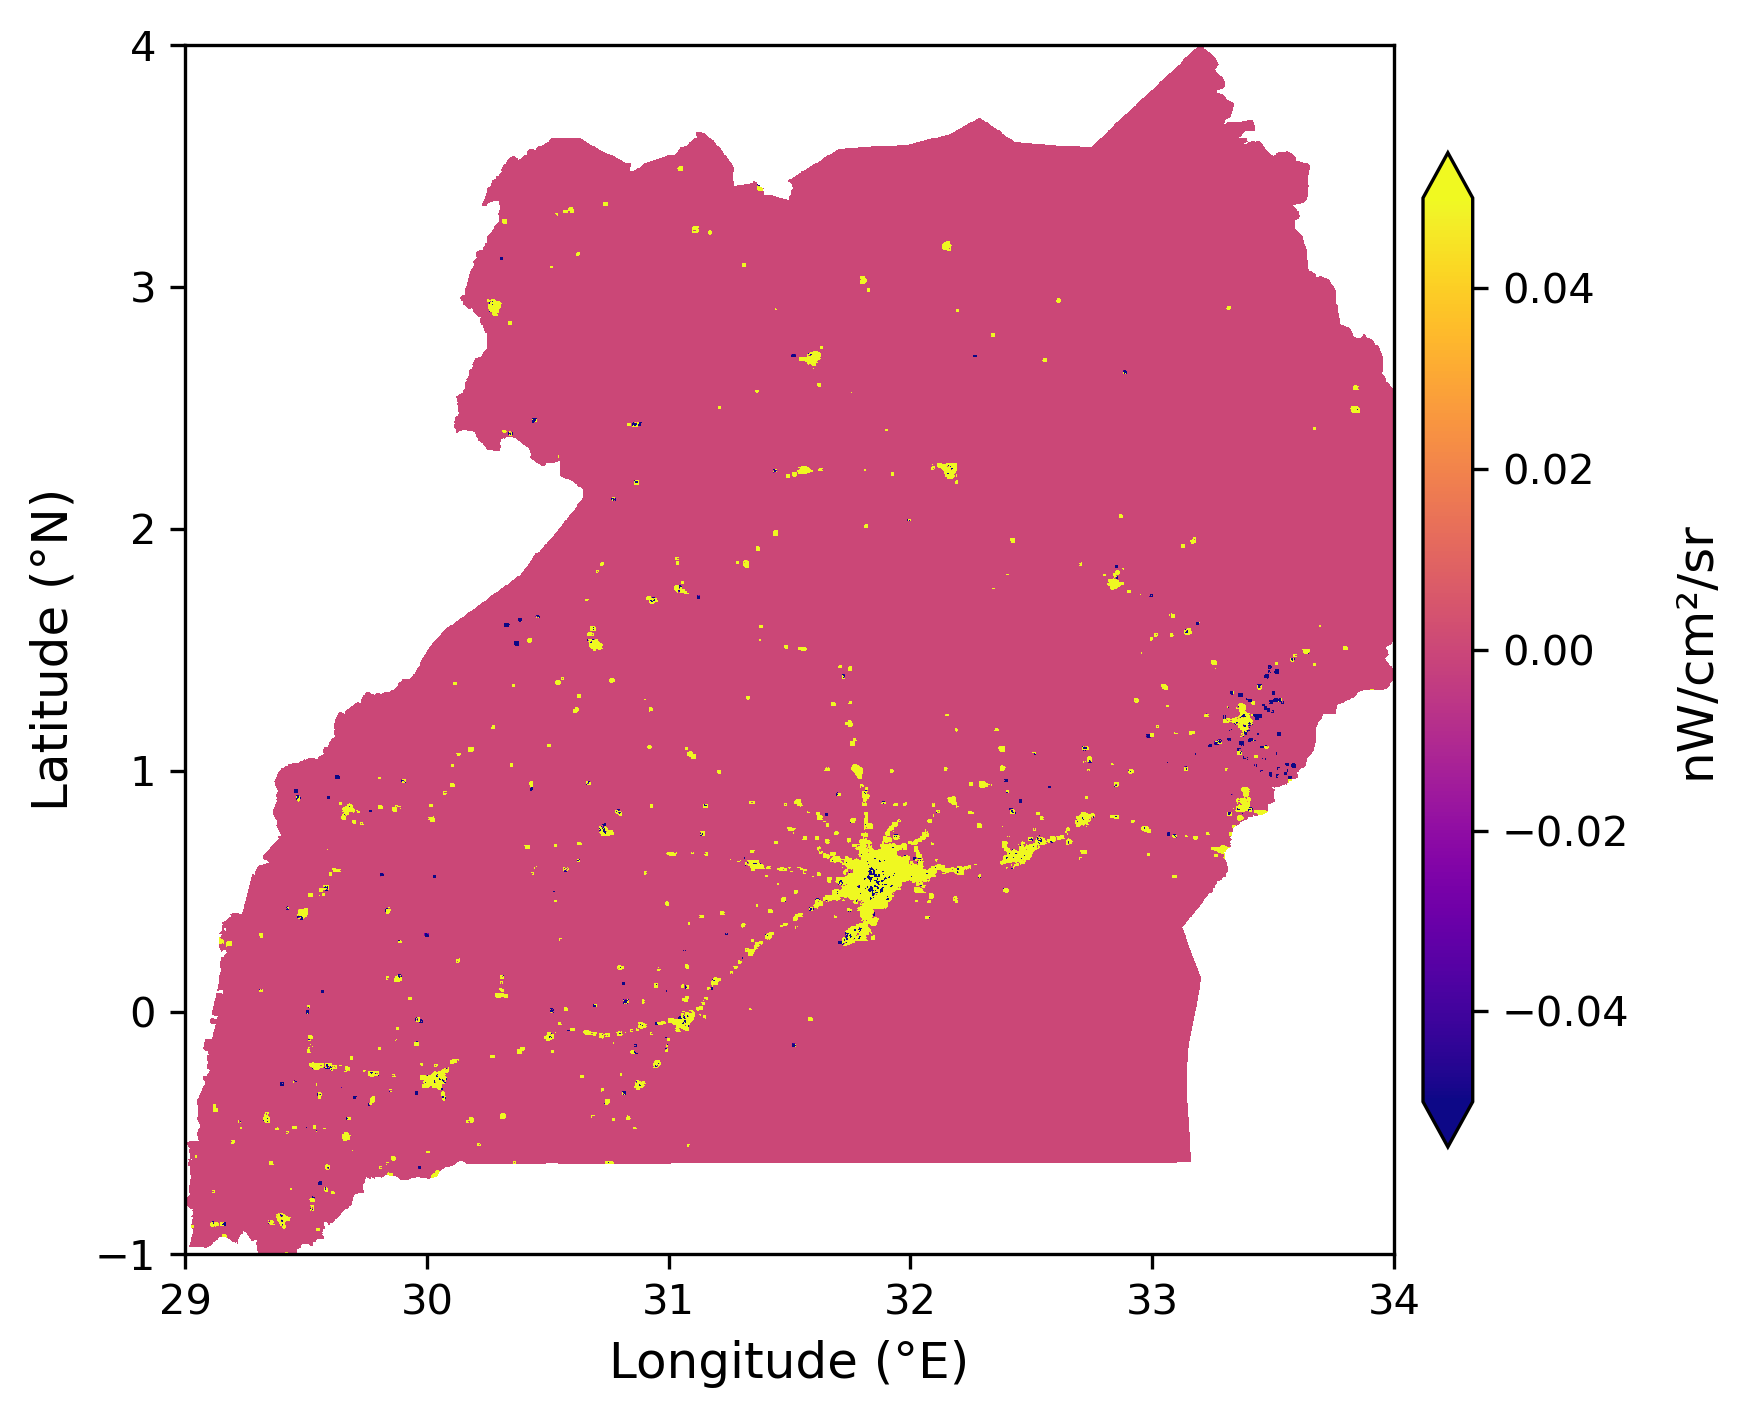

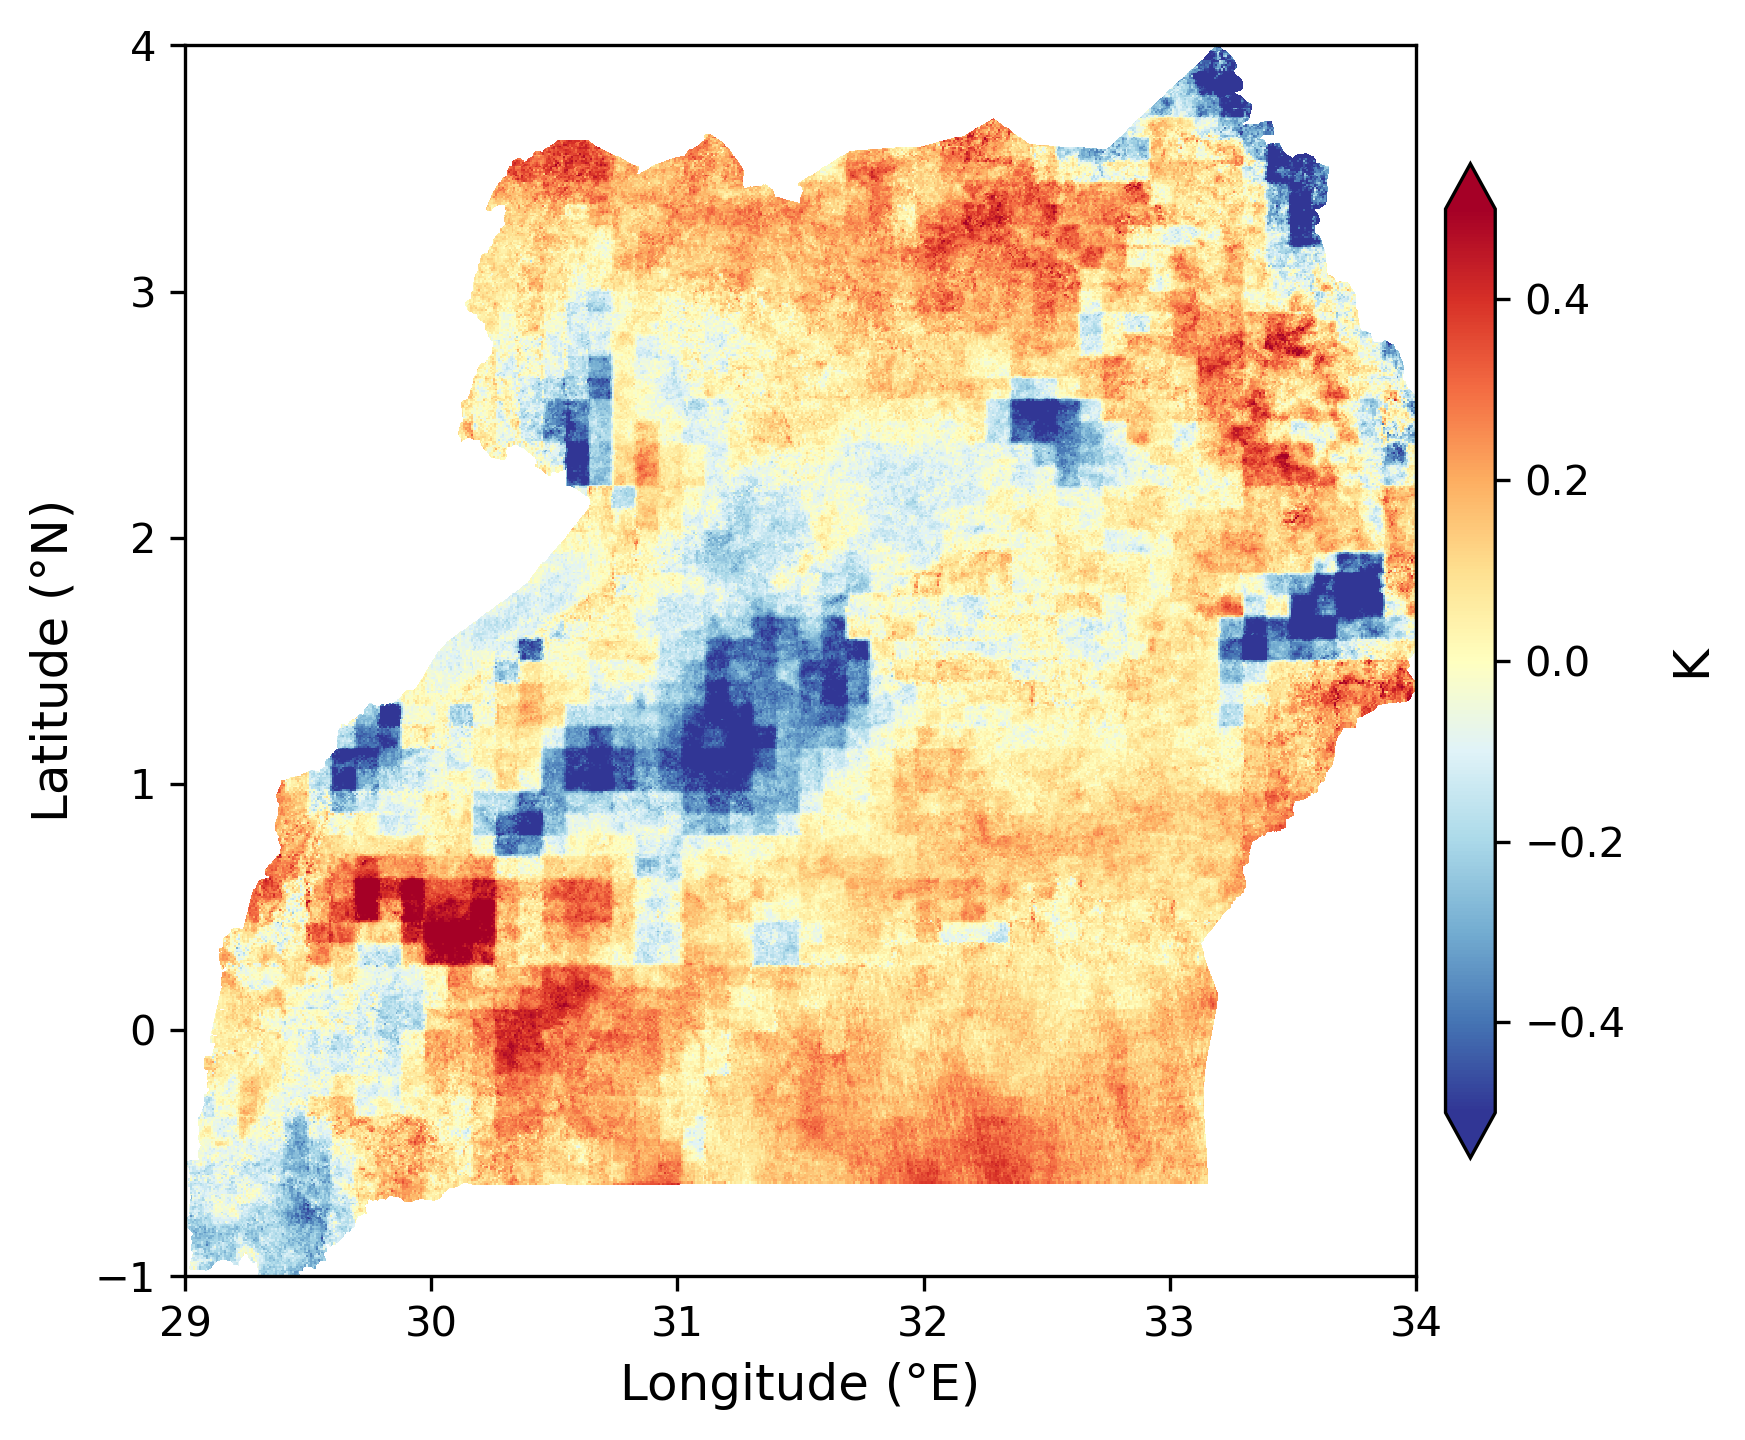

In [ ]:
# Set style for poster quality
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 300  # High DPI for poster quality
})

# Plot 1: VIIRS radiance Long Difference

t1 = merged.viirs_radiance.sel(time=slice("2012-12-31", "2013-12-31")).median("time")
t2 = merged.viirs_radiance.sel(time=slice("2018-12-31", "2019-12-31")).median("time")
viirs_subset_ld = (t2 - t1)

fig1, ax1 = plt.subplots(1, 1, figsize=(6, 5))
im1 = viirs_subset_ld.drop_vars(["band", "spatial_ref"]).squeeze().plot.imshow(
    ax=ax1, 
    robust=True,
    cmap='plasma',
    add_colorbar=False
)
ax1.set_xlabel('Longitude (°E)')
ax1.set_ylabel('Latitude (°N)')
ax1.set_aspect('equal')
ax1.tick_params(labelsize=10)

# Clean colorbar for VIIRS
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, pad=0.02, extend='both')
cbar1.set_label('nW/cm²/sr', rotation=90, labelpad=10)

plt.tight_layout()
plt.savefig('uganda_viirs_ld.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Plot 2: MODIS LST Long Difference 

t1 = merged.modis_lst.sel(time=slice("2012-12-31", "2013-12-31")).median("time")
t2 = merged.modis_lst.sel(time=slice("2018-12-31", "2019-12-31")).median("time")
modis_subset_ld = (t2 - t1)

fig2, ax2 = plt.subplots(1, 1, figsize=(6, 5))
im2 = modis_subset_ld.drop_vars(["band", "spatial_ref"]).squeeze().plot.imshow(
    ax=ax2,
    robust=True,
    cmap='RdYlBu_r',
    add_colorbar=False
)
ax2.set_xlabel('Longitude (°E)')
ax2.set_ylabel('Latitude (°N)')
ax2.set_aspect('equal')
ax2.tick_params(labelsize=10)

# Clean colorbar for MODIS LST
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, pad=0.02, extend='both')
cbar2.set_label('K', rotation=90, labelpad=10)

plt.tight_layout()
plt.savefig('uganda_modis_lst_ld.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [17]:
merged["modis_lst_demeaned"] = (merged["modis_lst"] - merged["modis_lst"].mean("time"))
merged["modis_lst_demeaned"] = merged["modis_lst_demeaned"] - merged["modis_lst_demeaned"].mean(["latitude", "longitude"])

merged["viirs_radiance_demeaned"] = (merged["viirs_radiance"] - merged["viirs_radiance"].mean("time"))
merged["viirs_radiance_demeaned"] = merged["viirs_radiance_demeaned"] - merged["viirs_radiance_demeaned"].mean(["latitude", "longitude"])
merged["cell_id"] = (list(merged.sizes.keys()), np.broadcast_to(np.arange(merged.sizes["latitude"] * merged.sizes["longitude"]).reshape([merged.sizes["latitude"], merged.sizes["longitude"]]), merged.sizes.values()))
for dim in ["latitude", "longitude"]:
    merged.coords[dim] = merged.coords[dim].astype("int16")
merged.coords["time"] = pd.Series(merged.coords["time"]).dt.year

In [ ]:
merged_df = merged[["modis_lst_demeaned", "viirs_radiance_demeaned", "cell_id", "subdivisions"]].to_dataframe().dropna().drop(columns=["spatial_ref"])
merged_df[["modis_lst_demeaned_l1", "viirs_radiance_demeaned_l1"]] = merged_df.groupby("cell_id")[["modis_lst_demeaned", "viirs_radiance_demeaned"]].shift()

results = smf.ols('modis_lst_demeaned ~ viirs_radiance_demeaned', data=merged_df).\
    fit(cov_type='cluster', cov_kwds={'groups': merged_df['subdivisions']})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     modis_lst_demeaned   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.499
Date:                Tue, 26 Aug 2025   Prob (F-statistic):            0.00295
Time:                        10:33:51   Log-Likelihood:                -68935.
No. Observations:            10105344   AIC:                         1.379e+05
Df Residuals:                10105342   BIC:                         1.379e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2.908e-11   9.29e-12      3.129      0.002    1.09e-11    4.73e-11
viirs_radiance_demeaned     0.0305      0.010      3.082      0.002       0.011       0.050
==============================================================================
Omnibus:                  1737206.966   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14146786.937
Skew:                           0.601   Prob(JB):                         0.00
Kurtosis:                       8.671   Cond. No.                         9.37
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [29]:
with open("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/gnt/experiments/uganda_regression.tex", "w") as file:
    file.write(results.summary(slim=True).as_latex())

In [35]:
results_2 = smf.ols('modis_lst_demeaned ~ viirs_radiance_demeaned + I(viirs_radiance_demeaned ** 2)', data=merged_df).\
    fit(cov_type='cluster', cov_kwds={'groups': merged_df['subdivisions']})
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     modis_lst_demeaned   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.313
Date:                Tue, 26 Aug 2025   Prob (F-statistic):            0.00714
Time:                        11:54:40   Log-Likelihood:                -68930.
No. Observations:            10105344   AIC:                         1.379e+05
Df Residuals:                10105341   BIC:                         1.379e+05
Df Model:                           2                                         
Covariance Type:              cluster                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2.675e-06   2.94e-06      0.908      0.364    -3.1e-06    8.45e-06
viirs_radiance_demeaned             0.0310      0.010      3.055      0.002       0.011       0.051
I(viirs_radiance_demeaned ** 2)    -0.0002      0.000     -1.011      0.312      -0.001       0.000
==============================================================================
Omnibus:                  1737250.287   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14146461.623
Skew:                           0.601   Prob(JB):                         0.00
Kurtosis:                       8.670   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""